In [35]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [34]:
from IPython.display import HTML

# Diffusion analysis of molecules on graphene

## Molecules on a graphene device
F4TCNQ molecules deposited onto a graphene device are excited by current pulses and dance around on the surface, under different gating conditions.

In [31]:
HTML('<img src="./device_figure.png" width=500px>')

## Tracking molecule trajectories
The molecules' positions are tracked and used to find different diffusion modes.

In [26]:
HTML('<img src="./demo_movie.gif">')

In [ ]:
# Code that analyzes all videos in the dataset under different gating and source-drain voltage conditions
dps = []
ms = []

for i, emd in enumerate(emds):
    print(i)
    m = MotionAnalyzer(emd.sets, emd.voltages_temperatures, emd.folder, heater=False, drift_correction = False)
    m.analyze(plot_gif = False)
    ms.append(m)
    dp = DiffusionPlotter(m)
    dp.plot_diffusion(suppress_output=True)
    dps.append(dp)

# Finding the mean squared displacement (MSD) and diffusion constant

An example dataset of all detected particle tracks:

In [88]:
dp.t3s[0]

,y,x,mass,size,ecc,orientation,angle,signal,raw_mass,ep,frame,particle
frame_index,,,,,,,,,,,,
0,5.288669,220.407381,14.772648,2.143588,0.048641,0.036411,0.036411,0.882053,-47.380718,-0.071098,0,0
0,244.760611,71.709111,6.136170,1.916036,0.199959,-2.449299,-2.449299,0.388937,48.992244,0.172023,0,1
0,243.766887,212.715084,6.837645,1.882803,0.190990,2.382059,2.382059,0.458390,43.150078,0.217007,0,2
0,243.131932,14.527729,5.948647,1.982851,0.207539,2.375776,2.375776,0.357683,52.405212,0.153441,0,3
0,226.769344,174.078355,7.091149,1.861644,0.189000,2.404784,2.404784,0.475753,40.950087,0.240711,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8,15.315323,82.341532,8.965761,1.851656,0.184826,-2.271253,-2.271253,0.650741,-37.329383,-0.091128,8,21
8,5.178808,220.302744,15.285176,2.056441,0.030757,0.096815,0.096815,0.921883,-46.051636,-0.079109,8,0
8,243.205391,71.934232,6.706244,1.903182,0.199176,-2.449354,-2.449354,0.426597,46.524180,0.197847,8,1


The displacement of particles between each two successive frames is plotted as a scatter plot, and follows a discrete pattern, 
with unit spacing equal to the graphene lattice constant, revealing that the molecules have discrete adsorption geometries on graphene. Blue dots indicate molecular movement involving direct translation, orange dots indicate molecular movement which involves a rotation.

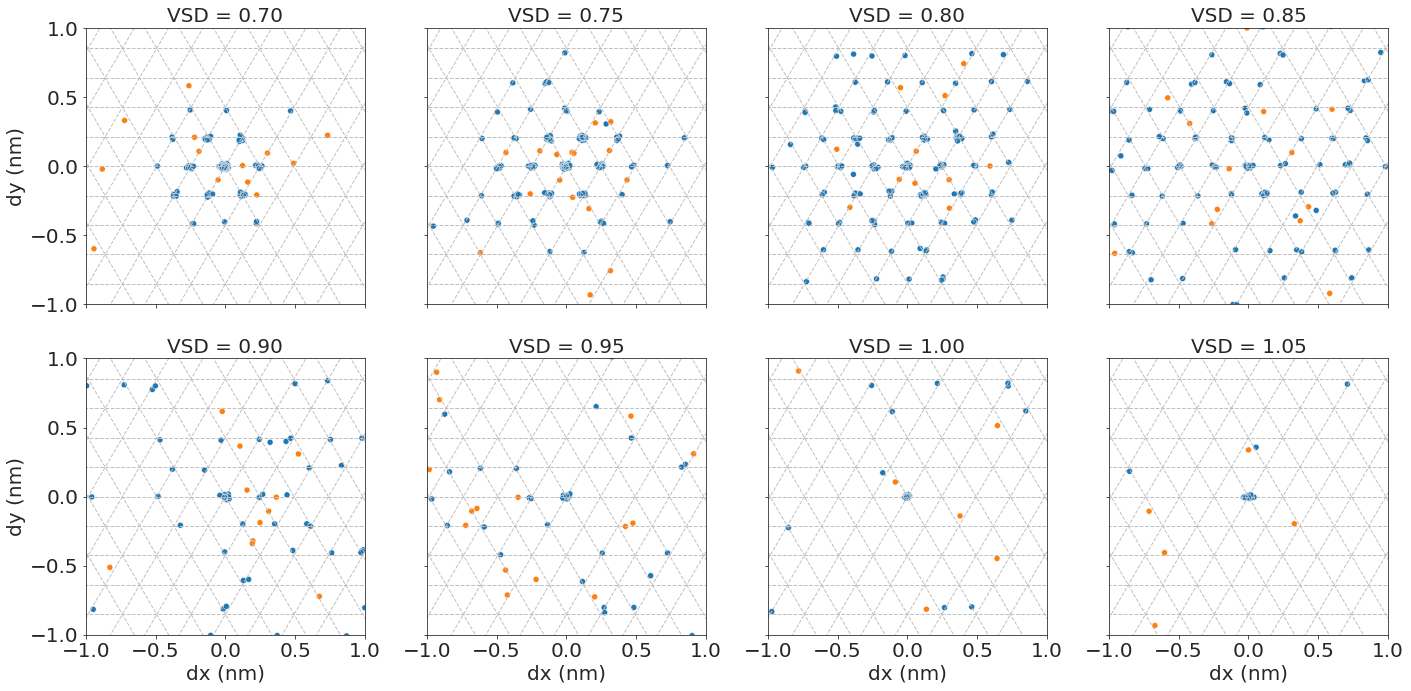

In [59]:
dp.plot_scatter()

Given the list of all particle positions, we can find the mean squared displacement (MSD) as a function of time. The MSD is linear and indicates normal Brownian diffusion:

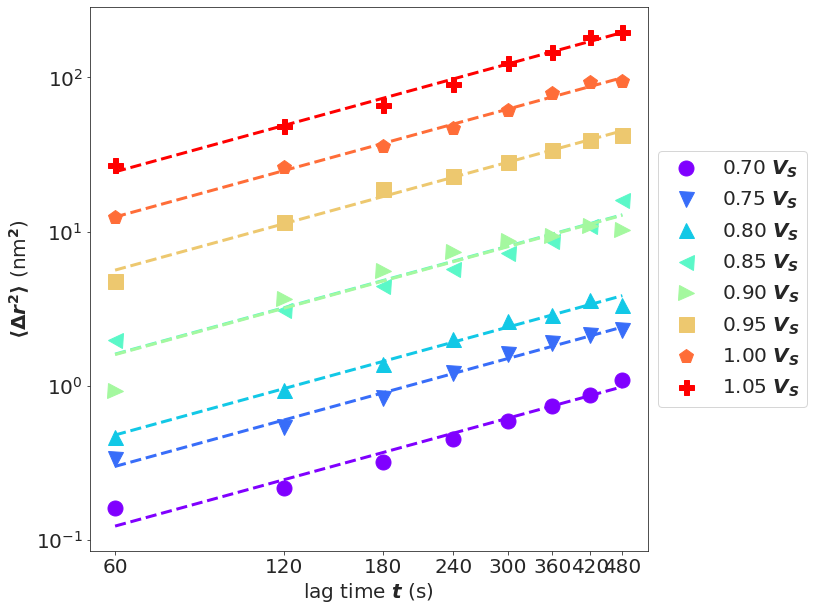

In [57]:
dp.plot_msd()

We found that the diffusion constant strongly depends on the gate voltage, and has a transition point at VG = -20V.

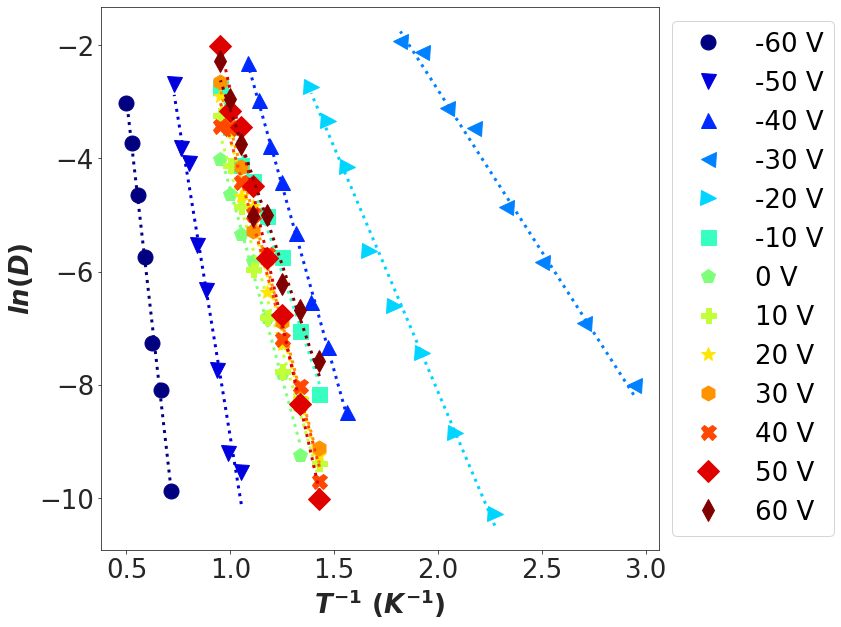

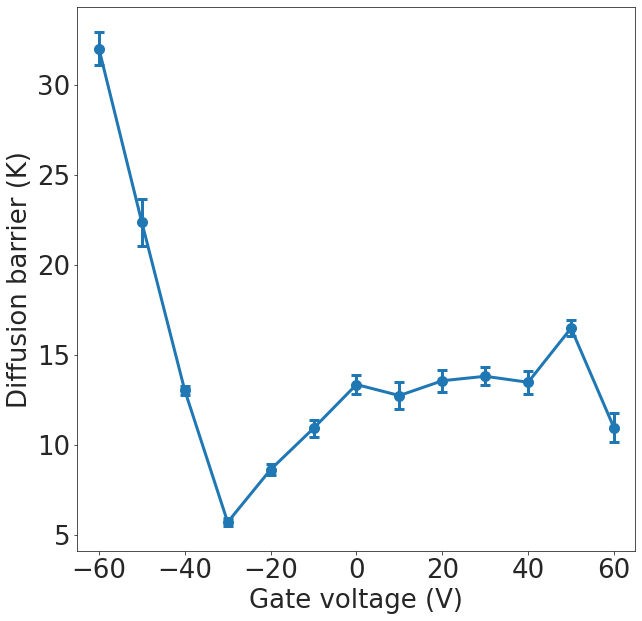

In [104]:
gdde = GDDE(dps, emds)
gdde.plot_D_vs_T_lin()
gdde.plot_Ea_vs_Vg()

## Molecule orientation detection
I detect molecular orientation by measuring its image moment, then I used k-means clustering to identify their discrete orientations. I then use this information to monitor how the molecules' orientation changes during diffusion. We discovered that charged molecules primarily move by translation only, but uncharged molecules also rotate when moving!

In [39]:
HTML('<img src="./molecule_orientation_figure.png" width=500px>')

Under the condition when molecules are charged at positive gate voltages (VG>0), the translation mode dominates:

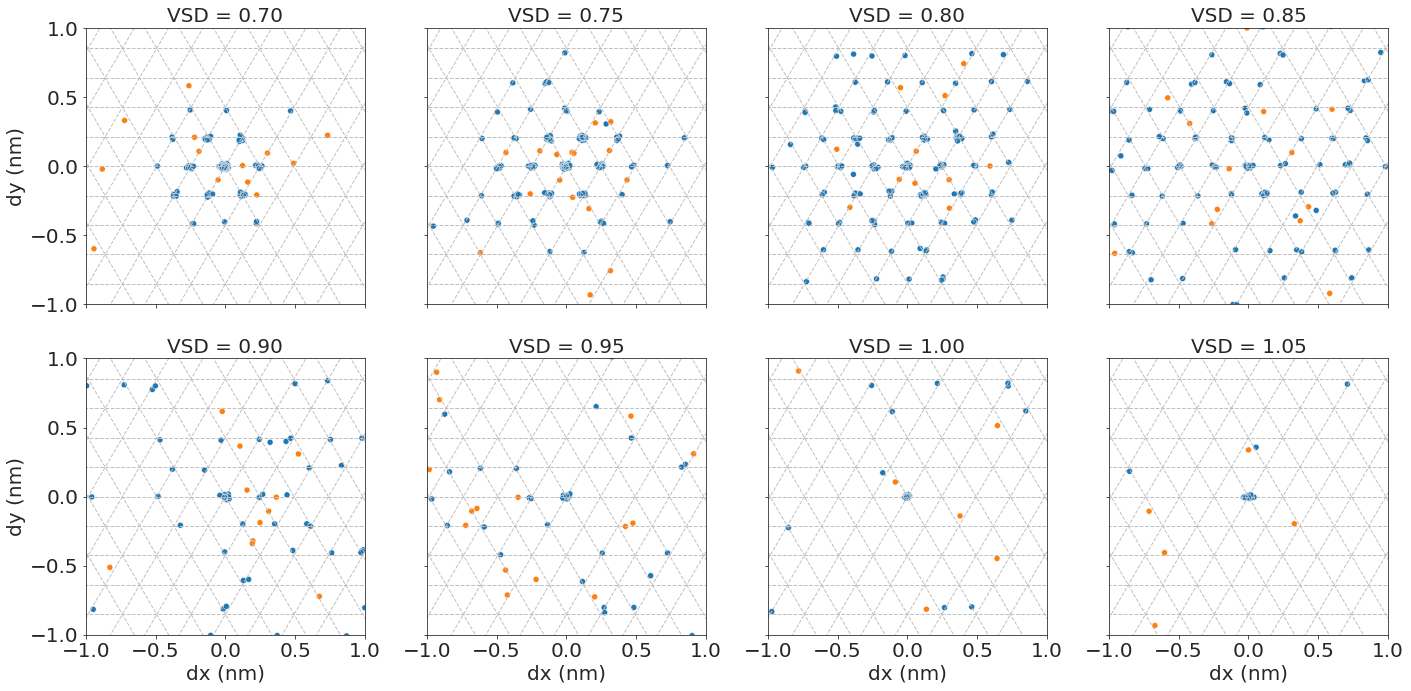

In [108]:
dp.plot_scatter()

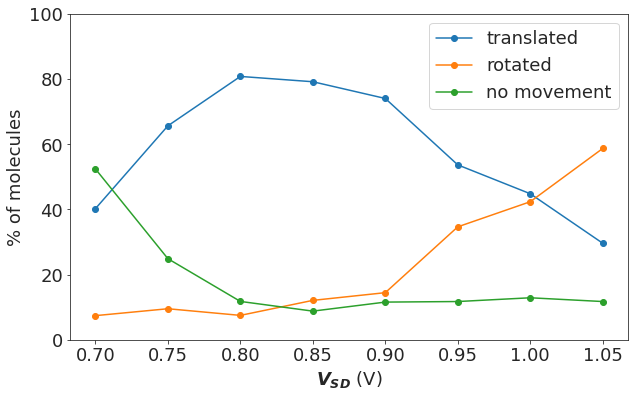

In [65]:
dp.plot_rotated_frac()

However, under negative gate voltages, movement by a rotation dominates:

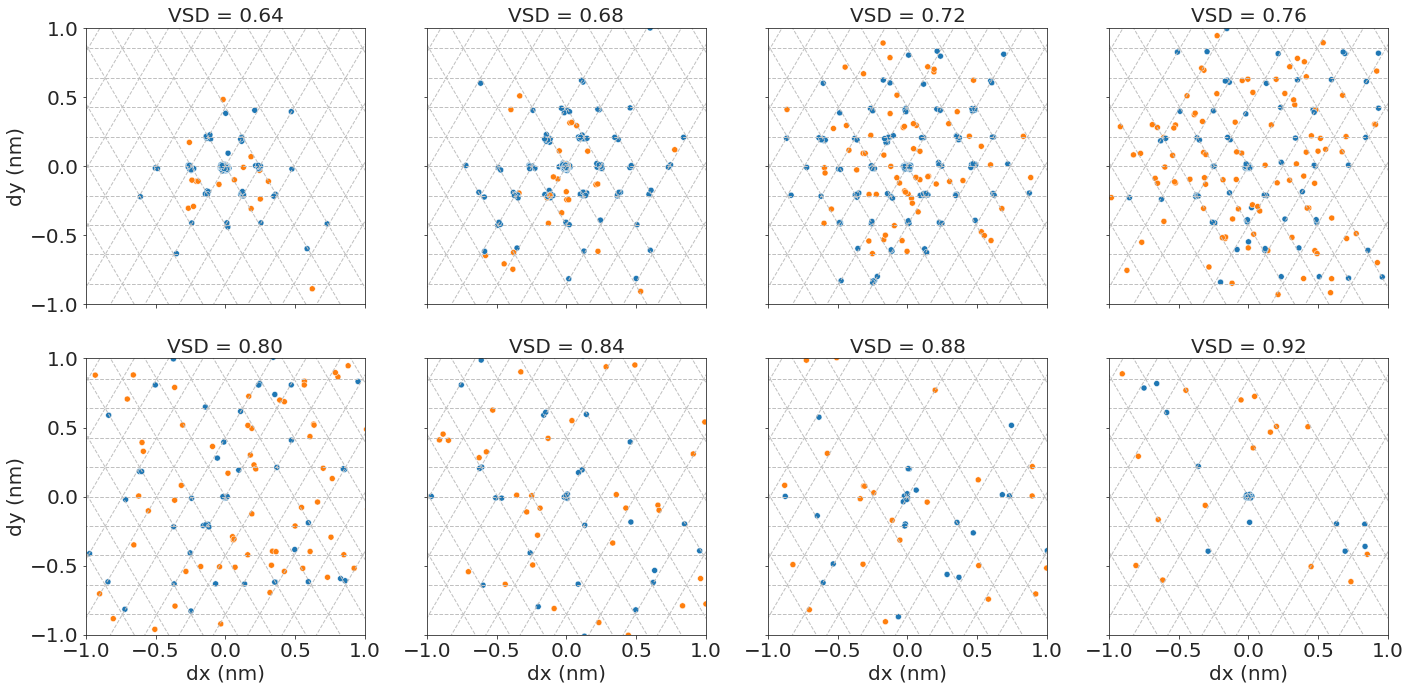

In [109]:
dps[2].plot_scatter()

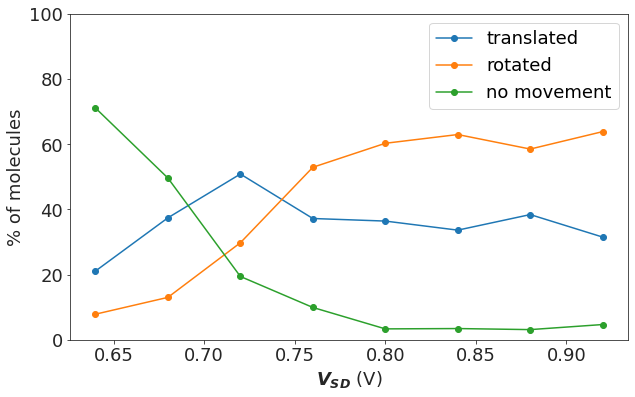

In [107]:
dps[2].plot_rotated_frac()

We sort the molecular hops into discrete bins, revealing different movement patterns for charged and uncharged molecules.

Charged molecules:

0.70
0.75
0.80
0.85
0.90
0.95
1.00
1.05


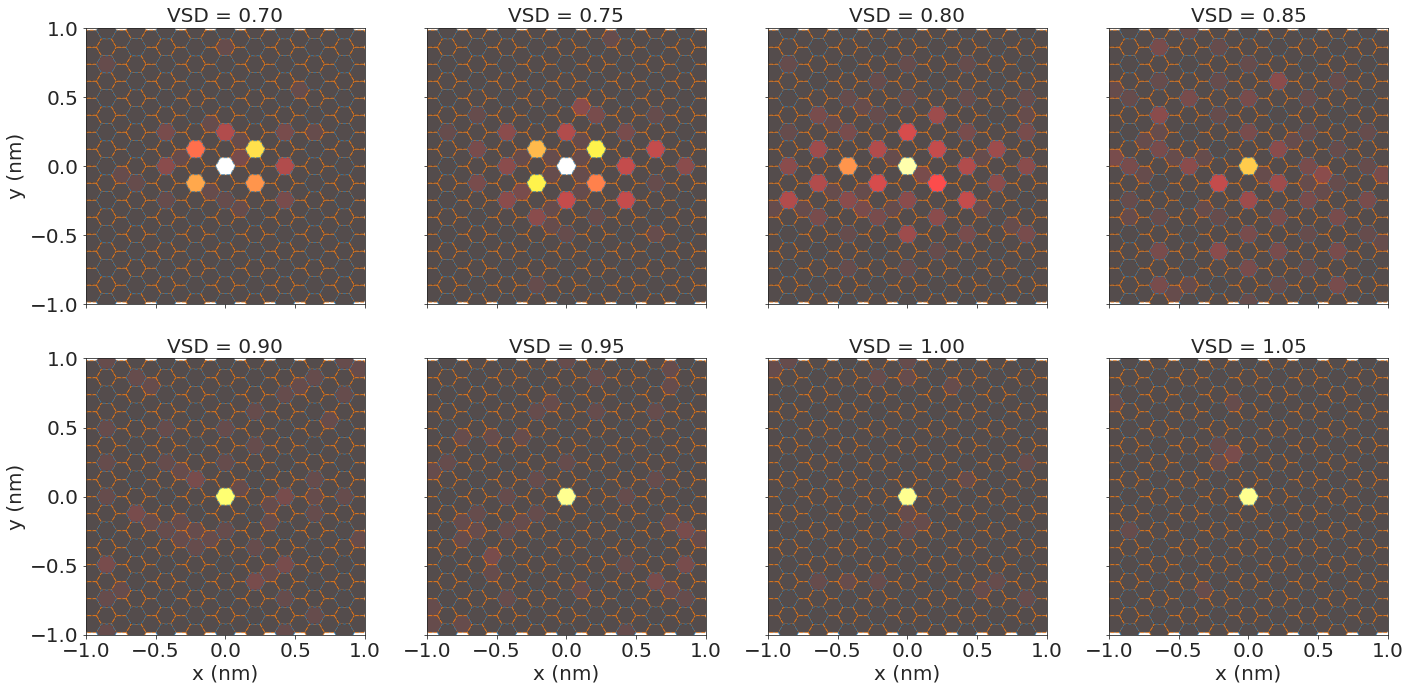

In [110]:
dp.plot_hexbins()

Uncharged molecules:

0.64
0.68
0.72
0.76
0.80
0.84
0.88
0.92


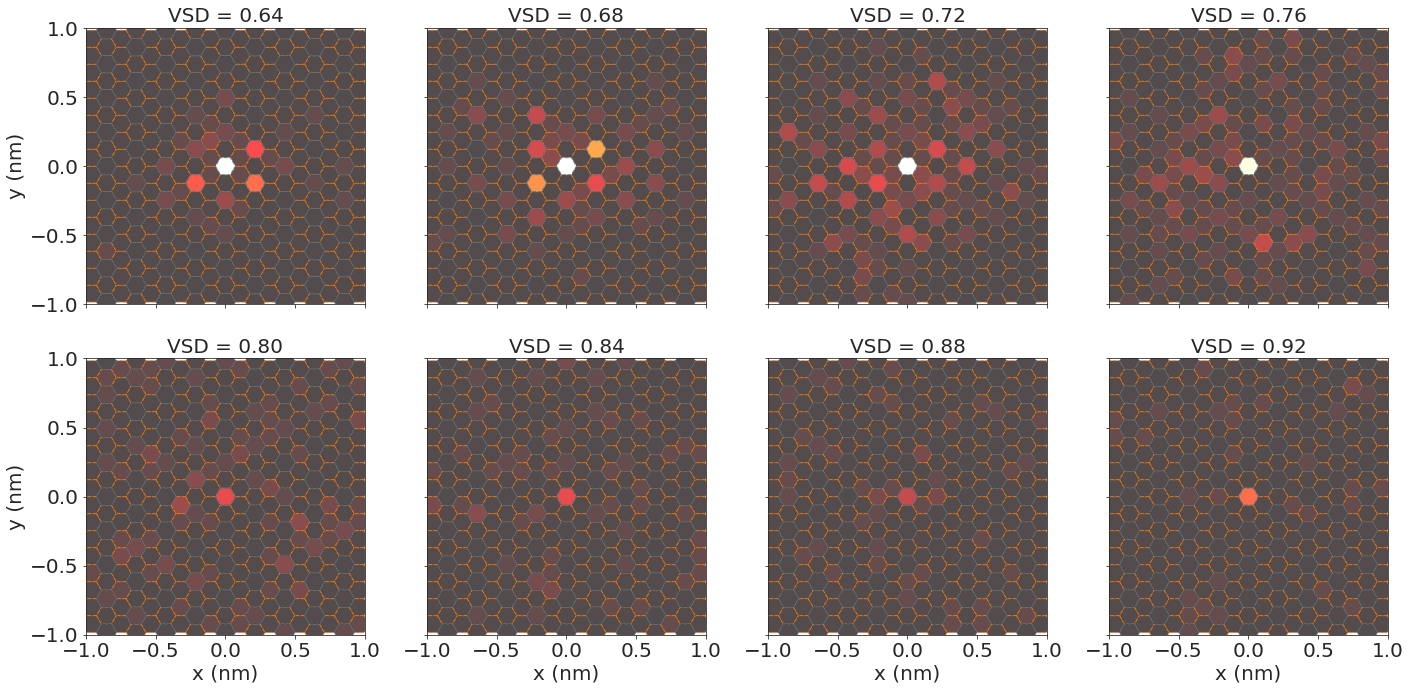

In [112]:
dps[2].plot_hexbins()

# MotionAnalyzer class

In [79]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

from sklearn.linear_model import LinearRegression
from collections import namedtuple
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import stats
from scipy.stats import linregress
from scipy.optimize import curve_fit
import imageio
import seaborn as sns
import itertools

%matplotlib inline

import numpy as np
import pandas as pd
import trackpy as tp

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename
from shutil import copyfile

import pims
import glob
from sxmreader import SXMReader
import yaml

from sklearn.cluster import KMeans

class ExpMetaData:
    
    def __init__(self, sets=None, Vg = None, voltages_temperatures=None, folder = None):
            self.sets = sets
            self.Vg =Vg
            self.voltages_temperatures = voltages_temperatures
            self.folder = folder
            return None

class MotionAnalyzer:
    """
    A class used to analyze motion of particles on a series of images.

    Attributes
    ----------
    fileranges : range []
        a list of filenumber ranges corresponding to each set of images, e.g. [range(801,815), range(815,829)]  
    voltages_temperatures : np.float32 [] 
        a list of voltages or temperatures corresponding to each set of images
    D_constants:
    
    drifts:
    em: DataFrame []
    Ensemble averaged Mean Square Displacement (EMSD)
    ed: [<x>,<y>]
    Ensemble averaged Displacement
    SXM_PATH 
    : [str []]
        a list of list of paths corresponding to the filenames of each image
    ANALYSIS_FOLDER : str
        the folder where the analysis results will be saved.
    

    Methods
    -------
    analyze():
        Performs batch particle tracking and linking of tracks, calculates diffusion constants
        and drifts.
    
    """
           
    def __init__(self, fileranges=None, voltages_temperatures=None, folder_name = None, heater = False, drift_correction = True, manual_drift_particles = None):
        
        if any((fileranges == None) or (voltages_temperatures == None)):
            print('no filerange or voltages/temperatures specified')
            return
        if len(fileranges) != len(voltages_temperatures):
            print('number of sets and voltages/temperatures don\'t match')
        self.heater = heater
        self.drift_correction = drift_correction
        self.fileranges = fileranges
        self.voltages_temperatures = voltages_temperatures    
        self.SXM_PATH = [[folder_name + "/Image_{0:03}.sxm".format(i) for i in fileranges[j]] for j in range(len(fileranges))]
        self.SET_NAME = "{}-{}/".format(min([min(x) for x in fileranges]), max([max(x) for x in fileranges]))
        self.ANALYSIS_FOLDER = "./analysis/" + folder_name + "_" + self.SET_NAME
        self.MOVIE_FOLDER = self.ANALYSIS_FOLDER + "movies/"
        self.PARAMS_FILENAME = "params.yaml"
        if not os.path.exists(self.ANALYSIS_FOLDER):
            os.makedirs(self.ANALYSIS_FOLDER)
        if not os.path.exists(self.ANALYSIS_FOLDER):
            os.makedirs(self.MOVIE_FOLDER)
        self._set_search_params()
        #self.analyze_drift()
        #self.plot_average_drift()
    
    def analyze(self, plot_gif=False):
        self.drifts = []
        self.v_drift_mag = []
        self.D_constants = []
        self.D_constants2 = []
        self.msd_slope = []
        self.msd_intercept = []
        self.mu_hats = []
        self.ed = []
        self.em = []
        self.frames = []
        self.displacements = []
        self.testframe = []
        self.total_molecules = []
        self.total_moved = []
        self.total_rotated= []
        self.total_translated = []
        #self.hops = []
        self.rotated_D_constants = []
        self.translated_D_constants = []
        self.t3s=[]
        
        
        for i, path in enumerate(self.SXM_PATH):
            frames = SXMReader(path, correct=None)
            self.frames.append(frames)
            self.NM_PER_PIXEL = frames.meters_per_pixel * 1e9 
            print(path)
            molecule_size, min_mass, max_mass, separation, min_size, max_ecc, adaptive_stop, search_range, _ = self.PARAMS[i]
            f = tp.batch(frames, molecule_size, minmass=min_mass, separation=separation)
            t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop)
            t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
                 (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
            t2 = tp.filter_stubs(t, 3)
            # Compare the number of particles in the unfiltered and filtered data.
            print('Before:', t['particle'].nunique())
            print('After:', t2['particle'].nunique())
            
            if plot_gif == True:
                moviename = "{}-{}".format(min(self.fileranges[i]), max(self.fileranges[i]))
                singlemoviefolder = self.MOVIE_FOLDER + moviename + "/"
                if not os.path.exists(singlemoviefolder):
                    os.makedirs(singlemoviefolder)
                mpl.rcParams.update({'font.size': 10, 'font.weight':'bold'})
                mpl.rc('image', origin='lower')
                mpl.rc('text',usetex =False)
                mpl.rc('text',color='black')


                fns = []
                for j, frame in enumerate(frames):
                    self.testfig= plt.figure(figsize=(5,5))
                    plt.axis('off')
                    self.testframe = tp.plot_traj(t2[(t2['frame']<=j)], superimpose=frames[j], label=False, origin='lower')
                    self.testframe.invert_yaxis()
                    self.testfig=self.testframe.figure
                    fn = singlemoviefolder + "Image_{}.png".format(self.fileranges[i][j])
                    
                    self.testfig.savefig(fn,bbox_inches='tight')
                    fns.append(fn)
                    plt.clf()
                    plt.axis('off')

                mpl.rc('text',color='black')
                images = []
                for fn in fns:
                    images.append(imageio.imread(fn))
                imageio.mimsave(singlemoviefolder + moviename + '.gif', images, duration=0.5)
                #self._cleanup_png(singlemoviefolder)

            # Compute drifts
            d = tp.compute_drift(t2)
            d.loc[0] = [0, 0]
            t3 = t2.copy()
            if self.drift_correction:
                t3 = tp.subtract_drift(t2)
            self.t3s.append(t3)
            #if manual_drift_particles != None:
            #    t3 = tp.subtract_drift(t2,t2.loc[:,['x','y']][t2.particle==manual_drift_particles[i]])
                
            # Storing drifts
            self.drifts.append(d)
            
            # Method 1 of calculating D: variance of all displacements of Delta_t=1
            displacements = self._calculate_displacements(t3)
            self.displacements.append(displacements)
            self.D_constants.append((displacements.dx.var() + displacements.dy.var()) / 4/ self.DIFFUSION_TIME) # r^2 = x^2 + y^2 = 2Dt + 2Dt
            #self.hops.append(displacements)
            self.mu_hats.append(np.mean(displacements[['dx', 'dy']], axis=0))
            
            # Compute number of rotated molecules
            rotated = displacements.rotated.sum()
            moved = len( displacements[displacements.dr > 0.1].index)
            total_molecules = len(displacements.index)
            self.total_molecules.append(total_molecules)
            self.total_moved.append(moved)
            self.total_rotated.append(rotated)
            self.total_translated.append(moved-rotated)
            
            # Compute D separately for rotated and translated molecules
            rotated_displacements = displacements[(displacements.rotated==True)]
            translated_displacements = displacements[(displacements.rotated==False)]
            self.rotated_D_constants.append((rotated_displacements.dx.var() + rotated_displacements.dy.var()) / 4/ self.DIFFUSION_TIME)
            self.translated_D_constants.append((translated_displacements.dx.var() + translated_displacements.dy.var()) / 4/ self.DIFFUSION_TIME)

            
            # Method 2 of calculating D: linear fit to MSD with weights
            em = tp.emsd(t3, frames.meters_per_pixel*1e9, self.DIFFUSION_TIME, max_lagtime=len(frames) ,detail=True)
            self.em.append(em)
            self.ed.append([em['<x>'],em['<y>']])
            X = em.index * self.DIFFUSION_TIME
            X = X.values.reshape(-1, 1)
            w = em.N
            y = em['msd']
            model = LinearRegression().fit(X, y, sample_weight = w)
            self.msd_slope.append(model.coef_[0])
            self.msd_intercept.append(model.intercept_)
            self.D_constants2.append(model.coef_[0]/4)
            
            #result = linregress(em.index * self.DIFFUSION_TIME, em['msd'])
            #self.msd_slope.append(result.slope)
            #self.msd_intercept.append(result.intercept)
            #self.D_constants2.append(result.slope/4)
            
        self.v_drift_mag= np.linalg.norm(self.mu_hats, 2, axis=1)
            
    def _cleanup_png(self, singlemoviefolder):
        filelist = glob.glob(os.path.join(singlemoviefolder, "*.png"))
        for f in filelist:
            os.remove(f)
            
    def _snap_to_orientation(self, angles):
        kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(angles).reshape(-1, 1))
        idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
        lut = np.zeros_like(idx)
        lut[idx] = np.arange(3)
        return lut[kmeans.labels_]
        #angle_2 = 2*angle
        #if (angle_2 <= offset_theta -np.pi/6):
        #    return 2*np.pi/3
        #elif ((angle_2 > offset_theta -np.pi/6) & (angle_2 <= offset_theta + np.pi/6)):
        #    return 0
        #elif (angle_2 > offset_theta + np.pi/6):
        #    return 2*2*np.pi/3
                        
    def _calculate_displacements(self, t, delta=1):
        displacements = pd.DataFrame()
        for j in range(t.frame.max() - delta):
                displacements = displacements.append(tp.relate_frames(t, j, j + delta) * self.NM_PER_PIXEL, ignore_index=True)
        displacements = displacements.dropna()
        offset_theta = -15/180*np.pi
        displacements['orientation'] = self._snap_to_orientation(displacements.angle)
        displacements['orientation_b'] = self._snap_to_orientation(displacements.angle_b)
        displacements["rotated"] = (displacements['orientation']!=displacements['orientation_b']).astype("int")
        return displacements    
    
    def _set_search_params(self):
        with open('params.yaml') as f:
            params = yaml.load(f, Loader=yaml.FullLoader)       
        Params = namedtuple(
                    'Params', 
                    ['molecule_size', 
                     'min_mass',
                     'max_mass',
                     'separation',
                     'min_size',
                     'max_ecc',
                     'adaptive_stop',
                     'search_range',
                     'diffusion_time'])
        self.DIFFUSION_TIME = params['diffusion_time']
        self.PARAMS = [Params(**params) for i in range(len(self.voltages_temperatures))]
        copyfile(self.PARAMS_FILENAME, self.ANALYSIS_FOLDER + self.PARAMS_FILENAME)
    
from sklearn.neighbors import NearestNeighbors
from matplotlib import patches

class DiffusionPlotter(MotionAnalyzer):
    
    """
    A class used to plot diffusive motion of particles using results from a MotionAnalyzer.
    
    Attributes
    ----------
    fileranges : range []
        a list of filenumber ranges corresponding to each set of images, e.g. [range(801,815), range(815,829)]  
    voltages_temperatures : np.float32 [] 
        a list of voltages or temperatures corresponding to each set of images
    D_constants:
    
    drifts:
    em : DataFrame []
        Ensemble averaged Mean Square Displacement (EMSD)
    ed : [<x>,<y>]
        Ensemble averaged Displacement
    SXM_PATH : [str []]
        a list of list of paths corresponding to the filenames of each image
    ANALYSIS_FOLDER : str
        the folder where the analysis results will be saved.
    

    Methods
    -------
    plot_drift_data()
    plot_diffusion()
    plot_msd()
    plot_ed()
    plot_v_over_D()
    
    """
    
    # Optionally, tweak styles.
    rc('animation', html='html5')
    mpl.rc('figure',  figsize=(10, 10))
    mpl.rc('image', cmap='gray')
    mpl.rc('image', origin='lower')
    mpl.rc('text',color='black')
    #mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
    
    def __init__(self, ma: MotionAnalyzer):
        self.__dict__ = ma.__dict__.copy()
        self.Ea = 0
        self.Ea_err = 0
        self.Ea_rotated = 0
        self.Ea_err_rotated = 0
        self.Ea_translated = 0
        self.Ea_err_translated = 0
        self.C0 = 0
        self.C0_err = 0
        self.Ea2 = 0
        self.Ea2_err = 0
        self.C02 = 0
        self.n_frame_displacements = []
        self.rots = []
        self.trunc_lattice = []
        self.btw_trunc_lattice = []
        self.a = 0.246
        self.hexbin_counts = []
        
        for i, voltagei in enumerate(self.voltages_temperatures):
            self.displacements[i]['VSD'] = "{0:.2f}".format(voltagei)
        self._calculate_rot()
        self.trunc_lattice, self.btw_trunc_lattice = self._calculate_lattice_points(self.a)
        
        self.mStyles = ["o","v","^","<",">","s","p","P","*","h","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
        self.cmap = plt.cm.get_cmap("rainbow")
        self.colors = self.cmap(np.linspace(0,1,len(self.voltages_temperatures)))

        
    def _rotate(self, coords, theta):
        x0, y0 = coords.dx, coords.dy
        x1 = x0*np.cos(theta) - y0*np.sin(theta)
        y1 = x0*np.sin(theta) + y0*np.cos(theta)
        return [x1, y1]

    def _calculate_rot(self):
        for test in self.displacements:    
            orientations = sorted(test.orientation.unique())
            rot_1 = test[test.orientation == orientations[0]].reset_index()
            rot_2 = test[test.orientation == orientations[1]].reset_index()
            rot_3 = test[test.orientation == orientations[2]].reset_index()

            ndr = pd.DataFrame(rot_1.apply(self._rotate, args = [-np.pi/3 + np.pi/2], axis=1).to_list())
            rot_1[['dx', 'dy']] = ndr
            ndr = pd.DataFrame(rot_2.apply(self._rotate, args = [-np.pi + np.pi/2], axis=1).to_list())
            rot_2[['dx', 'dy']] = ndr
            ndr = pd.DataFrame(rot_3.apply(self._rotate, args = [-5*np.pi/3 + np.pi/2], axis=1).to_list())
            rot_3[['dx', 'dy']] = ndr
            rot = pd.concat([rot_1,rot_2,rot_3])
            self.rots.append(rot)
     
    def plot_msd(self, ax = None):
        fig = plt.figure(figsize=(10,10))
        if ax is None:
            ax = plt.gca()
        for i in range(len(self.em)):
            if self.heater:
                labeltext = "{:.0f} $K$".format(self.voltages_temperatures[i])
            else:
                labeltext = "{:.2f} $V_S$".format(self.voltages_temperatures[i])
            p = ax.plot(self.em[i].index * self.DIFFUSION_TIME, self.em[i]['msd']- self.msd_intercept[i], 
                        label= labeltext, markersize=15, marker= self.mStyles[i], mfc = self.colors[i], mec=self.colors[i],
                        linestyle='None')
            #ax.legend()
            
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xticks([])
            ax.xaxis.set_major_locator(plt.MultipleLocator(self.DIFFUSION_TIME))
            ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2d'))
            
            ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ (nm$^2$)',
            xlabel='lag time $t$ (s)')
            x = np.linspace(self.DIFFUSION_TIME, self.DIFFUSION_TIME * len(self.em[i]),100)       
            ax.plot(x, self.msd_slope[i]*x, '--',  linewidth=3, color = self.colors[i])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.minorticks_off()
        #plt.savefig(self.ANALYSIS_FOLDER + "msd.png")
        return p
        
    
    def plot_drift_vectors(self, plotrange = 20, ax = None):
        #plt.figure(figsize=(10, 10))
        if ax is None:
            ax = plt.gca()
        #colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple', 'm']
        cmap = plt.cm.get_cmap("magma")
        colors = cmap(np.linspace(0,0.8,len(self.voltages_temperatures)))

        arrs = []
        
        for j, d in enumerate(self.drifts):
            #d['x']=-d['x']
            for i in range(1, len(d)):
                d0, d1 = d.loc[i - 1] * self.NM_PER_PIXEL, d.loc[i] * self.NM_PER_PIXEL
                ax.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
                shape='full', color=colors[j], length_includes_head=True, 
                zorder=0, head_length=0.5, head_width=0.5,linewidth=1.5)
            else:
                d0, d1 = d.loc[i - 1] * self.NM_PER_PIXEL, d.loc[i] * self.NM_PER_PIXEL
                arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
                shape='full', color=colors[j], length_includes_head=True, 
                zorder=0, head_length=0.5, head_width=0.5,linewidth=1.5, label=str(self.voltages_temperatures[j])))
        new_labels, arrs = zip(*sorted(zip(voltages_temperatures, arrs)))
        new_labels=["{:.1f}".format(s) + ' V' for s in new_labels]
        
        ax.legend(arrs, new_labels, fontsize=16, loc='upper left')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
        ax.tick_params(width=4, direction='in', length=10, top=True, right=True)
        
        #plt.title("Ensemble Drift, " + SXM_PATH[0][0] + " to {}".format(SXM_PATH[-1][-1]))
        ax.set_xlabel("x (nm)",fontsize=24,fontweight='bold')
        ax.set_ylabel("y (nm)",fontsize=24,fontweight='bold')
        ax.set_xlim(-plotrange, plotrange)
        ax.set_ylim(-plotrange, plotrange)
        ax.set_xticks(np.linspace(-plotrange,plotrange, 5))
        ax.set_yticks(np.linspace(-plotrange,plotrange, 5))
        ax.set_aspect('equal', 'box')
        #plt.savefig(self.ANALYSIS_FOLDER + "drift_vectors.png")
    
    def plot_drift_scalar(self,**kwargs):
        
        mag_displace = np.linalg.norm(self.mu_hats, 2, axis=1)
        new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(self.voltages_temperatures, mag_displace, self.D_constants)))
        mpl.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
        plt.figure(figsize=(10, 10))
        plt.plot(self.voltages_temperatures, mag_displace / self.DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
        # plt.plot(xx, yy / 1.5)
        plt.ylabel('drift velocity (nm / s)')
        plt.xlabel('Voltage (V)')
        plt.title('drift velocity magnitude')
        plt.savefig(self.ANALYSIS_FOLDER + "drift_scalar.png")
        
        plt.figure(figsize=(10, 10))
        mean_mu_hat = self._calculate_mean_axis(self.mu_hats)
        proj_mag_displace = np.array(self._project_to_mean_axis(self.mu_hats,mean_mu_hat))
        plt.plot(self.voltages_temperatures,  proj_mag_displace / self.DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
        plt.ylabel('drift velocity (nm / s)')
        plt.xlabel('Voltage (V)')
        plt.title('drift velocity projected onto average drift direction')
        plt.savefig(self.ANALYSIS_FOLDER + "drift_scalar_projected.png")

    def _label_axes(self, ax, xlabel, ylabel):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
    def plot_diffusion(self, suppress_output=False):
        tmpv, _sorted_D_constants = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.D_constants))))
        tmpv, _sorted_D_constants2 = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.D_constants2))))
        result = linregress(np.reciprocal(tmpv), np.log(_sorted_D_constants))
        result2 = linregress(np.reciprocal(tmpv), np.log(_sorted_D_constants2))
        self.Ea = -result.slope
        self.Ea_err = result.stderr
        self.C0 = result.intercept
        self.Ea2 = -result2.slope
        self.Ea2_err = result2.stderr
        self.C02 = result2.intercept
        #self.C0_err = result.intercept_stderr
        
        if not suppress_output:
            font = {
            'weight' : 'bold',
            'size'   : 22}

            mpl.rc('font', **font)
            mpl.rc('text',usetex =False)
            fig, ax = plt.subplots(figsize=(10,10))
            ax.plot(np.array(tmpv), _sorted_D_constants,'o-')
            #ax.plot(np.array(tmpv), _sorted_D_constants2,'o-')

            if self.heater == True:
                self._label_axes(ax,'Temperature (K)','Diffusion constant ($nm^2$ / s)')
            else:
                self._label_axes(ax,'Voltage (V)','Diffusion constant ($nm^2$ / s)')
            plt.savefig(self.ANALYSIS_FOLDER + "D_constant_exp.png")

            fig, ax1 = plt.subplots(figsize=(10,10))
            sns.regplot(np.reciprocal(tmpv), np.log(_sorted_D_constants), 'o-', ci=None, ax=ax1)
            #sns.regplot(np.reciprocal(tmpv), np.log(_sorted_D_constants2), 'o-', ci=None, ax=ax1)

            if self.heater == True:
                self._label_axes(ax1,'1/T (1/K)','Log Diffusion constant ($nm^2$ / s)')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{T}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result.slope,slope_stderr=result.stderr,intercept = result.intercept, intercept_stderr=result.intercept_stderr),xy=(350,500), xycoords='figure pixels')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{T}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result2.slope,slope_stderr=result2.stderr,intercept = result2.intercept, intercept_stderr=result2.intercept_stderr),xy=(350,400), xycoords='figure pixels')
            else:
                self._label_axes(ax1,'1/V (1/V)','Log Diffusion constant ($nm^2$ / s)')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{V}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result.slope,slope_stderr=result.stderr,intercept = result.intercept, intercept_stderr=result.intercept_stderr),xy=(350,500), xycoords='figure pixels')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{V}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result2.slope,slope_stderr=result2.stderr,intercept = result2.intercept, intercept_stderr=result2.intercept_stderr),xy=(350,400), xycoords='figure pixels')

            #plt.savefig(self.ANALYSIS_FOLDER + "logD_constant_lin.png")

            
    def plot_rotated_and_translated_diffusion(self, suppress_output=False):
        tmpv, _sorted_rotated_D_constants = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.rotated_D_constants))))
        tmpv, _sorted_translated_D_constants = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.translated_D_constants))))
        result = linregress(np.reciprocal(tmpv), np.log(_sorted_rotated_D_constants))
        result2 = linregress(np.reciprocal(tmpv), np.log(_sorted_translated_D_constants))
        self.Ea_rotated = -result.slope
        self.Ea_err_rotated = result.stderr
        self.Ea_translated = -result2.slope
        self.Ea_err_translated = result2.stderr
        
        if not suppress_output:
            font = {
            'weight' : 'bold',
            'size'   : 22}

            mpl.rc('font', **font)
            mpl.rc('text',usetex =False)
            fig, ax = plt.subplots(figsize=(10,10))
            ax.plot(np.array(tmpv), _sorted_rotated_D_constants,'o-')
            ax.plot(np.array(tmpv), _sorted_translated_D_constants,'o-')

            if self.heater == True:
                self._label_axes(ax,'Temperature (K)','Diffusion constant ($nm^2$ / s)')
            else:
                self._label_axes(ax,'Voltage (V)','Diffusion constant ($nm^2$ / s)')

            fig, ax1 = plt.subplots(figsize=(10,10))
            sns.regplot(np.reciprocal(tmpv), np.log(_sorted_rotated_D_constants), 'o-', ci=None, ax=ax1)
            sns.regplot(np.reciprocal(tmpv), np.log(_sorted_translated_D_constants), 'o-', ci=None, ax=ax1)

            if self.heater == True:
                self._label_axes(ax1,'1/T (1/K)','Log Diffusion constant ($nm^2$ / s)')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{T}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result.slope,slope_stderr=result.stderr,intercept = result.intercept, intercept_stderr=result.intercept_stderr),xy=(350,500), xycoords='figure pixels')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{T}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result2.slope,slope_stderr=result2.stderr,intercept = result2.intercept, intercept_stderr=result2.intercept_stderr),xy=(350,400), xycoords='figure pixels')
            else:
                self._label_axes(ax1,'1/V (1/V)','Log Diffusion constant ($nm^2$ / s)')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{V}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result.slope,slope_stderr=result.stderr,intercept = result.intercept, intercept_stderr=result.intercept_stderr),xy=(350,500), xycoords='figure pixels')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{V}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result2.slope,slope_stderr=result2.stderr,intercept = result2.intercept, intercept_stderr=result2.intercept_stderr),xy=(350,400), xycoords='figure pixels')

    def _calculate_mean_axis(self, mu_hats):
        return sum(mu_hats)/len(mu_hats)
    
    def _project_to_mean_axis(self, mu_hats, mean_mu_hat):
        return [np.dot(v,mean_mu_hat) for v in mu_hats]
    
    def plot_drift_data(self):
        self.plot_drift_vectors()
        self.plot_drift_scalar()
          
    def make_gif(self):
        pass
    
    def plot_ed(self):
        fig, axs = plt.subplots(3)
        t = [i for i in range(1,len(m.ed[0][0])+1)]
        vx = []
        vy = []
        for i, volt in enumerate(self.voltages_temperatures):
            slope, intercept, _, _, _ = linregress(t[:-5],self.ed[i][0][:-5])
            #print("vx={:.2f}nm/s".format(slope))
            vx.append(slope)
            slope, intercept, _, _, _ = linregress(t[:-5],self.ed[i][1][:-5])
            #print("vy={:.2f}nm/s".format(slope))
            vy.append(slope)
        mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})


        axs[0].plot(self.voltages_temperatures,vx,'o-')
        axs[0].set_title('ensemble averaged vx')
        axs[1].plot(self.voltages_temperatures,vy,'o-')
        axs[1].set_title('ensemble averaged vy')
        axs[2].plot(self.voltages_temperatures,np.array(vx)**2 + np.array(vy)**2,'o-')
        axs[2].set_title('ensemble averaged msd')

        for i in range(3):
            axs[i].set_xlabel('voltage(V)')
            axs[i].set_ylabel('velocity (nm/s)')
            if i == 2:
                axs[i].set_ylabel('velocity (nm/$s^2$)')
        plt.savefig(self.ANALYSIS_FOLDER + "ensemble averaged v.png")
    
    def plot_v_over_D(self):
        
        def exponenial_func(x, a, b):
            return a * np.exp(-b / x )
        
        plt.figure(figsize=(7,5))
        popt, pcov = curve_fit(exponenial_func, self.voltages_temperatures, self.D_constants)

        xx = np.linspace(self.voltages_temperatures[0], self.voltages_temperatures[-1], 100)
        yy = exponenial_func(xx, *popt)
        plt.plot(xx, yy)
        plt.plot(self.voltages_temperatures, np.array(self.D_constants), 'o')
        plt.xlabel('$V_{SD} (V)$')
        plt.ylabel('$D (nm^2/s)$')

        plt.figure(figsize=(7,5))
        mag_displace = np.linalg.norm(self.mu_hats, 2, axis=1)
        popt1, pcov1 = curve_fit(exponenial_func, self.voltages_temperatures, mag_displace)
        yy1 = exponenial_func(xx, *popt1)
        plt.plot(xx, yy1)
        
        plt.plot(self.voltages_temperatures, mag_displace , 'o')
        plt.xlabel('$V_{SD} (V)$')
        plt.ylabel('$v_{drift} (nm/s)$')

        plt.figure(figsize=(7,5))
        yy2 = exponenial_func(xx, *popt1)/exponenial_func(xx, *popt)
        plt.plot(xx, yy2)
        plt.plot(self.voltages_temperatures, mag_displace/np.array(self.D_constants), 'o')
        plt.xlabel('$V_{SD} (V)$')
        plt.ylabel('$v_{drift}/D \ (1/nm)$')
    
    def plot_scatter(self):
        sns.set_style('ticks')
        mpl.rcParams.update({'font.size': 20, 'font.weight':'normal'})
        test = pd.concat(self.displacements, axis=0)
        g = sns.FacetGrid(test, col="VSD", col_wrap=4, height=5, xlim = (-1,1), ylim= (-1,1), despine =False)
        theta = 0/180*np.pi
        #g.map(self._overlay_diffusion_grid)
        g.map(sns.scatterplot, "dx", "dy", "rotated")
        for ax in g.axes.flat:
            self._overlay_diffusion_grid(ax, theta = 0)
            ax.set_xlabel("dx (nm)")
            ax.set_ylabel("dy (nm)")
            ax.set_xticks([-1,-0.5,0,0.5,1])
            ax.set_yticks([-1,-0.5,0,0.5,1])
        #    ax.tick_params(labelleft=True,labelbottom=True)
    
    def plot_scatter_rot(self):
        sns.set_style('ticks')
        mpl.rcParams.update({'font.size': 20, 'font.weight':'normal'})
        test = pd.concat(self.rots, axis=0)
        g = sns.FacetGrid(test, col="VSD", col_wrap=4, height=5, xlim = (-1,1), ylim= (-1,1), despine =False)
        theta = 0/180*np.pi
        #g.map(self._overlay_diffusion_grid, theta = np.pi/2)
        g.map(sns.scatterplot, "dx", "dy", "rotated")
        for ax in g.axes.flat:
            self._overlay_diffusion_grid(ax, theta = np.pi/2)
            ax.set_xlabel("dx (nm)")
            ax.set_ylabel("dy (nm)")
            ax.set_xticks([-1,-0.5,0,0.5,1])
            ax.set_yticks([-1,-0.5,0,0.5,1])
            #ax.tick_params(labelleft=True,labelbottom=True)
    
    def _overlay_diffusion_grid(self, ax, plotrange = 6, theta = 0, **kwargs):
        a = 0.246
        for j, phi in enumerate(np.linspace(0,4*np.pi/3,3)):
            for i in np.arange(-plotrange,plotrange):
                x = np.linspace(-5,5,100)
                y = x*np.tan(theta+ phi) + i*a/np.cos(theta+ phi)*np.sqrt(3)/2
                ax.plot(x,y,color='silver', linestyle = '--', linewidth=1)
    
    def plot_rotated_frac(self):
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 18})
        plt.plot(self.voltages_temperatures,np.array(self.total_translated)/self.total_molecules*100,'o-',label='translated')
        plt.plot(self.voltages_temperatures,np.array(self.total_rotated)/self.total_molecules*100,'o-',label='rotated')
        plt.plot(self.voltages_temperatures,(np.array(self.total_molecules)-np.array(self.total_moved))/self.total_molecules*100,'o-',label='no movement')
        plt.legend()
        #plt.xlim([0.5,2.0])
        plt.ylim([0, 100])
        plt.xlabel('$V_{SD}$ (V)')
        plt.ylabel('% of molecules')
        
    def plot_rotated_abs(self):
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 18})
        plt.plot(self.voltages_temperatures,np.array(self.total_translated),'o-',label='translated')
        plt.plot(self.voltages_temperatures,np.array(self.total_rotated),'o-',label='rotated')
        plt.plot(self.voltages_temperatures,(np.array(self.total_molecules)-np.array(self.total_moved)),'o-',label='no movement')
        plt.plot(self.voltages_temperatures,np.array(self.total_molecules),'o-',label='total')
        plt.legend()
        #plt.xlim([0.5,2.0])
        #plt.ylim([0, 200])
        plt.xlabel('$V_{SD}$ (V)')
        plt.ylabel('# of molecules')
     
    def _calculate_n_frame_displacements(self, n):
        for t3 in self.t3s:
            self.n_frame_displacements.append(self._calculate_displacements(t3,n))
            
    def plot_n_frame_scatter(self, n):
        self._calculate_n_frame_displacements(n)
        x, y = 1, len(self.voltages_temperatures)
        fig, ax = plt.subplots(x, y, figsize=(20,40))

        for i, test in enumerate(self.n_frame_displacements):
            X, Y, Z = self._density_estimation(test.dx, test.dy)
            xmin, xmax, ymin, ymax = -20, 20, -20, 20

            # Show density 
            ax[i].imshow(np.rot90(np.fliplr(Z)), cmap=plt.cm.gist_earth_r,                                                    
                      extent=[xmin, xmax, ymin, ymax])

            # Add contour lines
            ax[i].contour(X, Y, Z)                                                                           
            ax[i].plot(test.dx, test.dy, 'r.', markersize=2)    
            ax[i].set_xlim([xmin, xmax])                                                                           
            ax[i].set_ylim([ymin, ymax])
            ax[i].set_title('{:.1f} V'.format(self.voltages_temperatures[i]))

    def _density_estimation(self, m1, m2):
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
        positions = np.vstack([X.ravel(), Y.ravel()])                                                       
        values = np.vstack([m1, m2])                                                                        
        kernel = stats.gaussian_kde(values)                                                                 
        Z = np.reshape(kernel(positions).T, X.shape)
        return X, Y, Z
    
    def plot_n_frame_scatter_overlay(self, n, threshold = 0.0007):
        self._calculate_n_frame_displacements(n)
        fig, ax = plt.subplots(figsize=(10,10))                   
        cmap = mpl.cm.get_cmap('coolwarm', len(self.n_frame_displacements))
        colors = cmap(np.arange(0,cmap.N))

        for i, test in enumerate(self.n_frame_displacements):
            X, Y, Z = self._density_estimation(test.dx, test.dy)

            # Add contour lines
            plt.contour(X, Y, Z, [threshold], colors=colors[i].reshape(-1,4))                                                                           
            ax.plot(test.dx, test.dy, '.', markersize=5, color= colors[i], label='{:.2f} V'.format(self.voltages_temperatures[i]))    
            ax.set_xlim([-10, 10])                                                                           
            ax.set_ylim([-10, 10])                                                                           
            plt.legend(fontsize=16)
            plt.grid('on')
            ax.set_xticks(np.linspace(-20,20,5))
            ax.set_yticks(np.linspace(-20,20,5))
            ax.tick_params(labelsize=16)
            ax.set_aspect('equal', 'box')
            
    def _avg_over_n_steps(self, arr, n):
        result = []
        for i in range(len(arr),0,-n):
            if i-n < 0: break
            result.append(np.mean(arr[i-n:i]))
        return result[::-1]
    
    def plot_rocket_tracks(self, set_i=-1, image_i = -1, valid_list = [], label_particles = False):
        x_end = self.t3s[set_i].groupby(by='particle').x.apply(list)
        y_end = self.t3s[set_i].groupby(by='particle').y.apply(list)

        if not valid_list:
            valid_list = x_end.index
        #valid_list = [2,24,8,12,19,22,7,6,5,9,13,10,1,21,16] # positive current
        #valid_list = [17,20,15,0,16,10,19,21,9,12,8,7,6,11] # negative current
        fig, ax = plt.subplots(figsize=(10,10))
        skip = 1
        for i in valid_list:
            ax.imshow(self.frames[set_i][image_i],cmap='gray')
            x_plt = self._avg_over_n_steps(x_end[i], skip)
            y_plt = self._avg_over_n_steps(y_end[i], skip)
            cmap = plt.cm.get_cmap("YlOrRd")
            colors = cmap(np.linspace(0.8,0,len(x_plt)+1))
            if label_particles:
                ax.text(x_plt[-1],y_plt[-1],f'{i}')
            for j, _ in enumerate(x_plt):
                if j == len(x_plt) + image_i: break
                ax.plot(x_plt[j:j+2], y_plt[j:j+2], color=colors[j], linewidth=3)

        ax.axis('off')
        return fig
    
    def plot_orientation_dist(self):
        #def draw_dividing_line(**kwargs):
        #    plt.axvline(30-15,color='r')
        #    plt.axvline(-30-15,color='r')     
        sns.set_style('ticks')
        concatted = pd.concat(self.displacements, axis=0)
        concatted['angle'] = concatted.angle*2/np.pi*180
        g = sns.FacetGrid(concatted, hue='orientation', col="VSD", col_wrap=4, height=5, xlim = (-180,180), despine =False)
        g.map(sns.distplot, "angle" , bins=20, kde=False)
        #g.map(draw_dividing_line)
        for ax in g.axes.flat:
            ax.tick_params(labelleft=True,labelbottom=True)
            ax.set_xticks([-60,0,60])
            ax.set_xlabel('Angle (deg.)')
            ax.set_ylabel('Counts')
        g.fig.tight_layout()
        
    def _calculate_dist(self, X0, X1):
        '''
        This function takes a list of subject coords of parcels X1 and 
        returns the nearest distance to a list of coords of target parcels X0
        e.g. calculate_dist(road_parcels, sold_parcels)
        '''
        neigh = NearestNeighbors(n_neighbors=1, radius=10.0, algorithm = 'kd_tree')
        neigh.fit(X0)
        dist, _ = neigh.kneighbors(X1)
        return dist
    
    def _overlay_lattice_points(self, ax, a, trunc_lattice, rot, color="C0", fill = False):
            hexbin_counts = []
            total_counts = len(rot)
            
            for _, point in trunc_lattice.iterrows():
                hexagon = patches.RegularPolygon((point.x, point.y), 6, radius=a/2/np.sqrt(3), orientation=np.pi/2, 
                                          edgecolor=color, linewidth=1, linestyle='--', fill = fill, alpha=0.7)
                ax.add_patch(hexagon)
                
                
                
                if fill:
                    cp_idx = rot.apply(lambda row: hexagon.contains_point(ax.transData.transform([row.dx,row.dy])), axis=1)
                    #ax.scatter(rot[cp_idx].dx, rot[cp_idx].dy,color='r')
                    count = len(rot[cp_idx])
                    
                    entry = [point.x, point.y, count, count/total_counts]
                    hexbin_counts.append(entry)
                    colormax = 25
                    hexagon.set_facecolor(plt.cm.hot(count/colormax))
                    #ax.text(point.x, point.y, f'{count}')
            return pd.DataFrame(data = hexbin_counts, columns = ['x','y','counts','prob'])
                    
    def _calculate_lattice_points(self, a):
            plotrange = 1
            a1 = np.array([np.sqrt(3)/2*a, a/2])
            a2 = np.array([np.sqrt(3)/2*a, -a/2])
            lattice_points = []
            btw_lattice_points = []
            for i in range(-30,30):
                for j in range(-30,30):
                    lattice_points.append(i*a1 + j*a2)
                    btw_lattice_points.append((i*a1 + j*a2)/2)
            lattice_points = np.array(lattice_points) 
            lattice_df = pd.DataFrame(lattice_points)
            lattice_df = lattice_df.rename(columns={0: "x", 1: "y"})
            trunc_lattice = lattice_df[(lattice_df.x <plotrange) & (lattice_df.x >-plotrange) & (lattice_df.y <plotrange) & (lattice_df.y >-plotrange)]

            btw_lattice_df = pd.DataFrame(np.array(btw_lattice_points)).rename(columns={0: "x", 1: "y"})
            btwdf = pd.merge(btw_lattice_df, lattice_df, how='left', on=['x', 'y'], indicator=True)
            btw_lattice_df = btwdf[btwdf['_merge'] == 'left_only']
            btw_trunc_lattice = btw_lattice_df[(btw_lattice_df.x <plotrange) & (btw_lattice_df.x >-plotrange) & (btw_lattice_df.y <plotrange) & (btw_lattice_df.y >-plotrange)]
            return trunc_lattice, btw_trunc_lattice

    
    def plot_hexbin(self, *args, **kwargs):
        rot = kwargs.pop('data')
        print(rot['VSD'].iloc[0])
        
        ax = plt.gca()
        trunc_lattice, btw_trunc_lattice = self._calculate_lattice_points(self.a)
        hexbin_counts_rot = self._overlay_lattice_points(ax, self.a, self.btw_trunc_lattice, rot, color = "C1", fill=True)
        hexbin_counts_tr = self._overlay_lattice_points(ax, self.a, self.trunc_lattice, rot, color = "C0", fill=True)
        self.hexbin_counts.append(pd.concat([hexbin_counts_rot, hexbin_counts_tr], ignore_index=True))


        dist_tran = self._calculate_dist(list(zip(self.trunc_lattice.x, self.trunc_lattice.y)), list(zip(rot['dx'], rot['dy'])))
        dist_rot = self._calculate_dist(list(zip(self.btw_trunc_lattice.x, self.btw_trunc_lattice.y)), list(zip(rot['dx'], rot['dy'])))
        rot = rot.copy()
        rot['rot_ind'] = dist_tran > dist_rot
        tran_p = rot[~rot['rot_ind']]
        rot_p = rot[rot['rot_ind']]
        #plt.scatter(tran_p.dx,tran_p.dy, color = 'C0')
        #plt.scatter(rot_p.dx,rot_p.dy, color = 'C1')

        self._format_plotrange(ax)


    def plot_hexbins(self):
        concatted = pd.concat(self.rots, axis=0)
        g = sns.FacetGrid(concatted, col="VSD", col_wrap=4, height=5, despine =False)
        g.map_dataframe(self.plot_hexbin)
        g.fig.tight_layout()
    
    def _format_plotrange(self, ax, plotrange = 1):
        ax.set_xlim([-plotrange,plotrange])
        ax.set_ylim([-plotrange,plotrange])
        ax.set_xticks(np.linspace(-plotrange,plotrange, 5))
        ax.set_yticks(np.linspace(-plotrange,plotrange, 5))
        ax.set_xlabel('x (nm)')
        ax.set_ylabel('y (nm)')

    
    def plot_rot(self, *args, **kwargs):
        rot = kwargs.pop('data')
        rot_1 = rot[rot.orientation == 0]
        rot_2 = rot[rot.orientation == 1]
        rot_3 = rot[rot.orientation == 2]
        ax = plt.gca()
        ax.scatter(rot_1.dx,rot_1.dy, label='0 deg.')
        ax.scatter(rot_2.dx,rot_2.dy, label='120 deg.')
        ax.scatter(rot_3.dx,rot_3.dy, label='240 deg.')
        ax.legend()
        
        self._format_plotrange(ax)
         
    def plot_rots(self):
        concatted = pd.concat(self.rots, axis=0)
        g = sns.FacetGrid(concatted, col="VSD", col_wrap=4, height=5, despine =False)
        g.map_dataframe(self.plot_rot)
        g.fig.tight_layout()

class GDDE: # Gate Dependent Diffusion Experiment
    def __init__(self, dps, emds):
        self.dps = dps
        self.emds = emds
        self.Vgs=[]
        for d in self.emds:
            self.Vgs.append(d.Vg)
        self.sorted_Vgs=[self.Vgs[i] for i in np.argsort(self.Vgs)]
        self.sorted_dps=[self.dps[i] for i in np.argsort(self.Vgs)]
        self.Eas = [dp.Ea for dp in self.sorted_dps]
        self.Ea_errs = [dp.Ea_err for dp in self.sorted_dps]
        self.Ea2s = [dp.Ea2 for dp in self.sorted_dps]
        self.Ea2_errs = [dp.Ea2_err for dp in self.sorted_dps]
        self.Ea_rotated = [dp.Ea_rotated for dp in self.sorted_dps]
        self.Ea_err_rotated =[dp.Ea_err_rotated for dp in self.sorted_dps]
        self.Ea_translated= [dp.Ea_translated for dp in self.sorted_dps]
        self.Ea_err_translated =[dp.Ea_err_translated for dp in self.sorted_dps]
        self.C0s = [dp.C0 for dp in self.sorted_dps]
        self.C02s = [dp.C02 for dp in self.sorted_dps]
        self.C0_errs = [dp.C0_err for dp in self.sorted_dps]
        
        # plotstyles
        font = {
        'family': 'sans-serif',
        'weight' : 'normal',
        'size'   : 26}

        mpl.rc('font', **font)
        self.mStyles = ["o","v","^","<",">","s","p","P","*","h","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
        self.cmap = plt.cm.get_cmap("jet")
        self.colors = self.cmap(np.linspace(0,1,len(self.sorted_dps)))
    
    def plot_D_vs_T_exp(self, savefig=False):
        fig = plt.figure(figsize=(10,10))
        for i, dp in enumerate(self.sorted_dps):
            plt.plot(dp.voltages_temperatures, dp.D_constants2,
                     color=self.colors[i], markersize=15, marker=self.mStyles[i],
                     label="{} V".format(self.sorted_Vgs[i]))
            #fit = np.exp(dp.C0 - dp.Ea*1/dp.voltages_temperatures)
            #plt.plot(dp.voltages_temperatures, fit, ':', color= colors[i], linewidth=3)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel('$T (K)$')
        plt.ylabel('$D (nm^2/s)$')
    
    def plot_D_vs_T_lin(self, savefig=False):
        fig = plt.figure(figsize=(10,10))
        for i, dp in enumerate(self.sorted_dps):
            plt.plot(1/dp.voltages_temperatures, np.log(dp.D_constants2), 
                     marker=self.mStyles[i], markersize = 15, color=self.colors[i], 
                     linestyle='None',
                     label="{} V".format(self.sorted_Vgs[i]))
            fit = dp.C02 - dp.Ea2*1/dp.voltages_temperatures
            plt.plot(1/dp.voltages_temperatures, fit, ':', color= self.colors[i], linewidth=3)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel('$T^{-1} \ (K^{-1})$')
        plt.ylabel('$ln(D)$')
        if savefig:
            plt.savefig("./diffusion_paper/D_fits.svg", bbox_inches='tight')
            
    def plot_Ea_vs_Vg(self, savefig = False):
        fig = plt.figure(figsize=(10,10))
        plt.errorbar(self.sorted_Vgs, self.Ea2s, self.Ea2_errs,marker='o',markersize=10,lw=3, capsize =5, capthick=3)
        plt.xlabel('Gate voltage (V)')
        plt.ylabel('Diffusion barrier (K)')
        plt.xlim([-65, 65])
        if savefig:
            plt.savefig("./diffusion_paper/Ea_VG.svg", bbox_inches='tight')
    
    def plot_msds(self):
        x, y = 4, 4
        #mpl.rc('figure',  figsize=(40, 40))
        fig, ax = plt.subplots(x, y, figsize=(40,40))
        for i, dp in enumerate(self.sorted_dps):
            j = i//x
            k = i%x
            dp.plot_msd(ax[j,k])
            
    def plot_msd(self, i):
        dp = self.sorted_dps[i]
        fig, ax = plt.subplots(figsize=(10,10))
        dp.plot_msd(ax)
        #fig.savefig("./diffusion_paper/msd.svg", bbox_inches='tight')
    
    def plot_scatter_rot(self, savefig = False):
        for i, dp in enumerate(self.sorted_dps):
            dp.plot_scatter_rot()
            fig = plt.gcf()
            if savefig:
                fig.savefig("./diffusion_paper/" + f"{self.sorted_Vgs[i]}" + "V_scatter.svg", bbox_inches='tight')
    
    def plot_rotated_frac(self, savefig = False):
        for i, dp in enumerate(self.sorted_dps):
            dp.plot_rotated_frac()
            fig = plt.gcf()
            if savefig:
                fig.savefig("./diffusion_paper/" + f"{self.sorted_Vgs[i]}" + "V_rotated_frac.svg", bbox_inches='tight')


# Loading data

In [10]:
emds = []
"""
#-20Vg
Vg = -20
voltages_temperatures = np.linspace(0.4, 0.64, 7, dtype=np.float32)
START = 306
SIZE = 8
FOLDER = "electromigration_33"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)
"""

#-20Vg
Vg = -20
voltages_temperatures = np.linspace(0.44, 0.72, 8, np.float32)
START = 268
SIZE = 8
FOLDER = "../electromigration_34"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#-30Vg
Vg = -30
voltages_temperatures = np.linspace(0.34, 0.55, 8, np.float32)
START = 371
SIZE = 8
FOLDER = "../electromigration_33"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#-40Vg
Vg = -40
voltages_temperatures = np.linspace(0.64, 0.92, 8, np.float32)
START = 463
SIZE = 8
FOLDER = "../electromigration_33"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

"""
#-50Vg
Vg = -50
voltages_temperatures = np.linspace(1.01, 1.43, 8, np.float32)
START = 550
SIZE = 8
FOLDER = "electromigration_33"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)
"""

#-50Vg
Vg = -50
voltages_temperatures = np.linspace(0.95, 1.37, 8, np.float32)
START = 357
SIZE = 8
FOLDER = "../electromigration_34"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#-60Vg
Vg = -60
voltages_temperatures = np.linspace(1.4, 2.0, 7, np.float32)
START = 636
SIZE = 8
FOLDER = "../electromigration_33"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#-10Vg
Vg = -10
voltages_temperatures = np.linspace(0.7, 1.05, 8, np.float32)
START = 731
SIZE = 8
FOLDER = "../electromigration_33"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#0Vg
Vg = 0
voltages_temperatures = np.linspace(0.75, 1.05, 7, np.float32)
START = 825
SIZE = 8
FOLDER = "../electromigration_33"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#10Vg
Vg = 10
voltages_temperatures = np.linspace(0.7, 1.05, 8, np.float32)
START = 908
SIZE = 8
FOLDER = "../electromigration_33"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#20Vg
Vg = 20
voltages_temperatures = np.linspace(0.7, 1.05, 8, np.float32)
START = 20
SIZE = 8
FOLDER = "../electromigration_34"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)


#30Vg
Vg = 30
voltages_temperatures = np.linspace(0.7, 1.05, 8, np.float32)
START = 103
SIZE = 8
FOLDER = "../electromigration_34"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#40Vg
Vg = 40
voltages_temperatures = np.linspace(0.7, 1.05, 8, np.float32)
START = 185
SIZE = 8
FOLDER = "../electromigration_34"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#50Vg
Vg = 50
voltages_temperatures = np.linspace(0.7, 1.05, 8, np.float32)
START = 442
SIZE = 8
FOLDER = "../electromigration_34"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)

#60Vg
Vg = 60
voltages_temperatures = np.linspace(0.7, 1.05, 8, np.float32)
START = 524
SIZE = 8
FOLDER = "../electromigration_34"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
emds.append(emd)